Prepare data for DBSCAN 

In [432]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan 
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr

In [433]:
# read data from csv file
fake_transaction = pd.read_csv('/Users/blackrose/Desktop/dsmp-2024-group-38/fake_transactional_data_24.csv')

In [434]:
fake_transaction.head()

,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date
0,10371.0,4.00,CINEMA,01/01/2025
1,88339.0,2.40,40544,01/01/2025
2,18555.0,2.40,85149,01/01/2025
3,18555.0,4.10,HIPSTER_COFFEE_SHOP,01/01/2025
4,80792.0,1.95,18555,01/01/2025


Generate summary statistics

In [435]:
fake_transaction.describe()

,from_totally_fake_account,monopoly_money_amount
count,1.014828e+07,1.014828e+07
mean,5.080502e+04,1.839348e+01
std,2.893710e+04,8.612323e+01
min,1.000000e+03,1.450000e+00
25%,2.530400e+04,2.650000e+00
50%,5.078100e+04,6.000000e+00
75%,7.563300e+04,1.200000e+01
max,1.009880e+05,1.995000e+03


In [436]:
fake_transaction.columns

Index(['from_totally_fake_account', 'monopoly_money_amount',
       'to_randomly_generated_account', 'not_happened_yet_date'],
      dtype='object')

count Null values

In [437]:
nanCount = fake_transaction.isnull().sum()
nanCount


from_totally_fake_account        0
monopoly_money_amount            0
to_randomly_generated_account    0
not_happened_yet_date            0
dtype: int64

Check correlation of features

In [438]:
# Selecting only numeric columns
numeric_columns = fake_transaction.select_dtypes(include=[np.number]).columns

# Creating an empty DataFrame for the correlation matrix
correlationMatrix = pd.DataFrame(index=numeric_columns, columns=numeric_columns)

# Calculating Pearson correlation coefficient for each pair of columns
for i in numeric_columns:
    for j in numeric_columns:
        correlationMatrix.loc[i, j] = np.round(pearsonr(fake_transaction[i], fake_transaction[j])[0], 2)
print(correlationMatrix)


                          from_totally_fake_account monopoly_money_amount
from_totally_fake_account                       1.0                   0.0
monopoly_money_amount                           0.0                   1.0


both correlation coefficients are 0 between the 2 variables, so there is no linear relationship between them

## Identify non-numerical values by feature

In [439]:
fake_transaction

,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date
0,10371.0,4.00,CINEMA,01/01/2025
1,88339.0,2.40,40544,01/01/2025
2,18555.0,2.40,85149,01/01/2025
3,18555.0,4.10,HIPSTER_COFFEE_SHOP,01/01/2025
4,80792.0,1.95,18555,01/01/2025
...,...,...,...,...
10148275,32185.0,2.65,COFFEE_SHOP,31/12/2025
10148276,32185.0,2.45,COFFEE_SHOP,31/12/2025
10148277,57569.0,14.00,WINE_BAR,31/12/2025
10148278,1490.0,9.00,57569,31/12/2025


In [440]:
for i, val in enumerate(fake_transaction['to_randomly_generated_account']):
    # check value is numeric?
    if str(val).isnumeric():
        # replace numeric with NaN
        fake_transaction.at[i, 'to_randomly_generated_account'] = pd.NA

# drop rows where 'to_randomly_generated_account' is NaN
fake_transaction.dropna(subset=['to_randomly_generated_account'], inplace=True)

fake_transaction.reset_index(drop=True, inplace=True)

print(fake_transaction)

         from_totally_fake_account  monopoly_money_amount  \
0                          10371.0                   4.00   
1                          18555.0                   4.10   
2                          18555.0                   4.45   
3                          18555.0                   1.45   
4                          18555.0                   5.00   
...                            ...                    ...   
7615512                    81404.0                   1.80   
7615513                    32185.0                   2.65   
7615514                    32185.0                   2.45   
7615515                    57569.0                  14.00   
7615516                    53444.0                   2.65   

        to_randomly_generated_account not_happened_yet_date  
0                              CINEMA            01/01/2025  
1                 HIPSTER_COFFEE_SHOP            01/01/2025  
2          TOTALLY_A_REAL_COFFEE_SHOP            01/01/2025  
3                  

# Feature 1 using All business

In [441]:
feature_1 = fake_transaction.pivot_table(index='from_totally_fake_account',
                                columns='to_randomly_generated_account',
                                values='monopoly_money_amount',
                                aggfunc='mean')
#feature_1.reset_index(drop=True, inplace=True)
feature_1.reset_index(inplace=True)

feature_1

to_randomly_generated_account,from_totally_fake_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
0,1000.0,NaN,2.397845,2.301282,108.930000,11.812500,NaN,NaN,NaN,3.900000,...,NaN,27.500,NaN,NaN,52.000000,13.18,11.475000,NaN,11.458333,52.490
1,1002.0,NaN,2.328302,2.378261,96.796000,11.672727,NaN,NaN,NaN,5.000000,...,NaN,NaN,113.0,NaN,41.285714,41.36,12.166667,49.990,NaN,52.490
2,1006.0,NaN,2.359322,2.327372,20.824375,11.600962,NaN,21.474237,21.8,3.666667,...,55.571429,NaN,NaN,NaN,42.750000,NaN,13.500000,14.490,NaN,49.990
3,1018.0,NaN,NaN,2.037500,18.994000,7.118182,NaN,21.521739,26.0,3.666667,...,NaN,NaN,NaN,NaN,NaN,14.09,1.500000,29.990,1.500000,10.000
4,1053.0,NaN,2.245455,2.554545,93.366667,11.734694,NaN,NaN,18.0,4.122222,...,NaN,41.590,NaN,NaN,43.000000,10.45,12.071429,29.990,14.555556,74.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8137,100931.0,NaN,2.297656,2.275385,19.745000,11.082278,NaN,23.925098,NaN,4.285714,...,81.000000,13.865,90.0,NaN,42.125000,24.32,13.000000,49.990,10.750000,14.995
8138,100934.0,NaN,2.344340,2.486275,87.778182,12.397196,20.000000,NaN,NaN,4.166667,...,NaN,15.910,NaN,NaN,NaN,NaN,11.769231,42.495,12.500000,NaN
8139,100947.0,NaN,2.295000,2.256481,100.068947,11.292000,11.333333,NaN,27.0,4.063830,...,NaN,21.820,90.0,NaN,24.000000,NaN,11.750000,19.990,12.062500,8.990
8140,100986.0,NaN,2.316667,2.650000,84.798571,11.344037,NaN,NaN,NaN,4.666667,...,NaN,15.450,38.0,NaN,22.000000,NaN,11.875000,24.990,11.857143,21.660


Some cell has NaN where people have not spent money so, I will replace these values with 0.

In [442]:
# replace NaN with 0
feature_1 = feature_1.fillna(0)
feature_1.head(10)

to_randomly_generated_account,from_totally_fake_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
0,1000.0,0.0,2.397845,2.301282,108.930000,11.812500,0.000000,0.000000,0.000000,3.900000,...,0.000000,27.50,0.0,0.0,52.000000,13.18,11.475000,0.000000,11.458333,52.49
1,1002.0,0.0,2.328302,2.378261,96.796000,11.672727,0.000000,0.000000,0.000000,5.000000,...,0.000000,0.00,113.0,0.0,41.285714,41.36,12.166667,49.990000,0.000000,52.49
2,1006.0,0.0,2.359322,2.327372,20.824375,11.600962,0.000000,21.474237,21.800000,3.666667,...,55.571429,0.00,0.0,0.0,42.750000,0.00,13.500000,14.490000,0.000000,49.99
3,1018.0,0.0,0.000000,2.037500,18.994000,7.118182,0.000000,21.521739,26.000000,3.666667,...,0.000000,0.00,0.0,0.0,0.000000,14.09,1.500000,29.990000,1.500000,10.00
4,1053.0,0.0,2.245455,2.554545,93.366667,11.734694,0.000000,0.000000,18.000000,4.122222,...,0.000000,41.59,0.0,0.0,43.000000,10.45,12.071429,29.990000,14.555556,74.99
5,1059.0,0.0,2.298889,2.298750,57.418000,11.176829,0.000000,0.000000,0.000000,4.928571,...,51.250000,34.09,0.0,0.0,43.000000,23.18,0.000000,10.000000,0.000000,0.00
6,1071.0,0.0,2.383636,2.413208,105.875000,6.709402,0.000000,0.000000,30.000000,4.625000,...,0.000000,45.45,81.5,0.0,42.000000,0.00,1.500000,26.656667,1.500000,29.99
7,1078.0,0.0,2.406154,2.337273,94.731111,12.091549,0.000000,0.000000,15.923077,4.500000,...,44.250000,39.09,0.0,0.0,60.000000,0.00,10.500000,9.000000,12.500000,0.00
8,1086.0,0.0,2.338596,2.441304,25.117500,5.737410,0.000000,22.218182,0.000000,5.000000,...,36.250000,34.55,117.0,0.0,41.000000,0.00,1.500000,74.990000,1.500000,41.99
9,1087.0,0.0,2.413986,2.406923,0.000000,11.515385,6.666667,0.000000,0.000000,5.250000,...,0.000000,24.55,0.0,0.0,43.000000,8.18,12.487500,0.000000,12.761905,29.99


In [443]:
# get all column names
feature_1.columns

Index(['from_totally_fake_account', 'ACCESSORY_SHOP', 'A_CAFE',
       'A_LOCAL_COFFEE_SHOP', 'A_SUPERMARKET', 'BAR', 'BOOKSHOP', 'BUTCHER',
       'BUTCHERS', 'CAFE', 'CHILDRENDS_SHOP', 'CHINESE_RESTAURANT',
       'CHINESE_TAKEAWAY', 'CINEMA', 'CLOTHES_SHOP', 'COCKTAIL_BAR',
       'COFFEE_SHOP', 'COMIC_BOOK_SHOP', 'COOKSHOP', 'DEPARTMENT_STORE',
       'DIY_STORE', 'DVD_SHOP', 'ELECTRONICS_SHOP', 'EXPRESS_SUPERMARKET',
       'FASHIONABLE_SPORTSWARE_SHOP', 'FASHION_SHOP', 'FLORIST', 'G&T_BAR',
       'GAME_SHOP', 'GOURMET_COFFEE_SHOP', 'GREENGROCER', 'GYM',
       'HIPSTER_COFFEE_SHOP', 'HIPSTER_ELECTRONICS_SHOP',
       'HOME_IMPROVEMENT_STORE', 'INDIAN_RESTAURANT', 'JEWLLERY_SHOP',
       'KEBAB_SHOP', 'KIDS_ACTIVITY_CENTRE', 'KIDS_CLOTHING_SHOP',
       'LARGE_SUPERMARKET', 'LIQUOR_STORE', 'LOCAL_BOOKSHOP', 'LOCAL_PUB',
       'LOCAL_RESTAURANT', 'LOCAL_WATERING_HOLE', 'LUNCH_PLACE', 'LUNCH_VAN',
       'NERDY_BOOK_STORE', 'PET_SHOP', 'PET_TOY_SHOP',
       'PRETENTIOUS_COFFEE_SH

In [444]:
# drop the 1st column because it is index value
feature_1 = feature_1.drop(columns=['from_totally_fake_account'])
feature_1

to_randomly_generated_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,CHILDRENDS_SHOP,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
0,0.0,2.397845,2.301282,108.930000,11.812500,0.000000,0.000000,0.0,3.900000,0.000000,...,0.000000,27.500,0.0,0.0,52.000000,13.18,11.475000,0.000,11.458333,52.490
1,0.0,2.328302,2.378261,96.796000,11.672727,0.000000,0.000000,0.0,5.000000,0.000000,...,0.000000,0.000,113.0,0.0,41.285714,41.36,12.166667,49.990,0.000000,52.490
2,0.0,2.359322,2.327372,20.824375,11.600962,0.000000,21.474237,21.8,3.666667,0.000000,...,55.571429,0.000,0.0,0.0,42.750000,0.00,13.500000,14.490,0.000000,49.990
3,0.0,0.000000,2.037500,18.994000,7.118182,0.000000,21.521739,26.0,3.666667,59.000000,...,0.000000,0.000,0.0,0.0,0.000000,14.09,1.500000,29.990,1.500000,10.000
4,0.0,2.245455,2.554545,93.366667,11.734694,0.000000,0.000000,18.0,4.122222,20.000000,...,0.000000,41.590,0.0,0.0,43.000000,10.45,12.071429,29.990,14.555556,74.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8137,0.0,2.297656,2.275385,19.745000,11.082278,0.000000,23.925098,0.0,4.285714,0.000000,...,81.000000,13.865,90.0,0.0,42.125000,24.32,13.000000,49.990,10.750000,14.995
8138,0.0,2.344340,2.486275,87.778182,12.397196,20.000000,0.000000,0.0,4.166667,0.000000,...,0.000000,15.910,0.0,0.0,0.000000,0.00,11.769231,42.495,12.500000,0.000
8139,0.0,2.295000,2.256481,100.068947,11.292000,11.333333,0.000000,27.0,4.063830,78.000000,...,0.000000,21.820,90.0,0.0,24.000000,0.00,11.750000,19.990,12.062500,8.990
8140,0.0,2.316667,2.650000,84.798571,11.344037,0.000000,0.000000,0.0,4.666667,0.000000,...,0.000000,15.450,38.0,0.0,22.000000,0.00,11.875000,24.990,11.857143,21.660


In [445]:
# find the number of row and column
feature_1.shape

(8142, 79)

We have 79 column (from 79 businesses)

In [446]:
# get some statistic values from dataset
feature_1.describe()

to_randomly_generated_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,CHILDRENDS_SHOP,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
count,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,...,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000
mean,1.012107,2.294299,2.296651,73.675676,11.227719,4.834824,4.999299,11.094166,4.191598,25.622156,...,25.904852,17.470078,14.556565,12.070744,25.221249,17.667536,9.706077,17.136904,9.747617,16.973205
std,4.721198,0.463676,0.451919,33.113623,1.554503,6.419806,9.372035,16.039906,1.095605,29.831505,...,30.212803,16.059297,31.181266,24.260434,20.491648,16.060775,4.658766,19.483967,4.604825,19.591090
min,0.000000,0.000000,0.000000,0.000000,3.433673,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.315179,2.316182,52.282115,11.209343,0.000000,0.000000,0.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.289167,0.000000,10.357143,0.000000
50%,0.000000,2.392991,2.391564,83.930556,11.707239,0.000000,0.000000,0.000000,4.377551,0.000000,...,0.000000,17.270000,0.000000,0.000000,34.000000,17.993750,11.516146,10.262000,11.500000,10.000000
75%,0.000000,2.455378,2.451671,97.431500,12.041667,11.812500,0.000000,18.333333,4.666667,53.600000,...,54.364583,30.910000,0.000000,0.000000,42.000000,30.910000,12.314683,24.990000,12.333333,24.990000
max,31.750000,2.847778,2.837838,149.780000,13.500000,20.000000,27.249024,75.000000,6.000000,100.000000,...,100.000000,50.000000,120.000000,75.000000,60.000000,50.000000,18.000000,74.990000,18.000000,74.990000


In [447]:
feature_1

to_randomly_generated_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,CHILDRENDS_SHOP,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
0,0.0,2.397845,2.301282,108.930000,11.812500,0.000000,0.000000,0.0,3.900000,0.000000,...,0.000000,27.500,0.0,0.0,52.000000,13.18,11.475000,0.000,11.458333,52.490
1,0.0,2.328302,2.378261,96.796000,11.672727,0.000000,0.000000,0.0,5.000000,0.000000,...,0.000000,0.000,113.0,0.0,41.285714,41.36,12.166667,49.990,0.000000,52.490
2,0.0,2.359322,2.327372,20.824375,11.600962,0.000000,21.474237,21.8,3.666667,0.000000,...,55.571429,0.000,0.0,0.0,42.750000,0.00,13.500000,14.490,0.000000,49.990
3,0.0,0.000000,2.037500,18.994000,7.118182,0.000000,21.521739,26.0,3.666667,59.000000,...,0.000000,0.000,0.0,0.0,0.000000,14.09,1.500000,29.990,1.500000,10.000
4,0.0,2.245455,2.554545,93.366667,11.734694,0.000000,0.000000,18.0,4.122222,20.000000,...,0.000000,41.590,0.0,0.0,43.000000,10.45,12.071429,29.990,14.555556,74.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8137,0.0,2.297656,2.275385,19.745000,11.082278,0.000000,23.925098,0.0,4.285714,0.000000,...,81.000000,13.865,90.0,0.0,42.125000,24.32,13.000000,49.990,10.750000,14.995
8138,0.0,2.344340,2.486275,87.778182,12.397196,20.000000,0.000000,0.0,4.166667,0.000000,...,0.000000,15.910,0.0,0.0,0.000000,0.00,11.769231,42.495,12.500000,0.000
8139,0.0,2.295000,2.256481,100.068947,11.292000,11.333333,0.000000,27.0,4.063830,78.000000,...,0.000000,21.820,90.0,0.0,24.000000,0.00,11.750000,19.990,12.062500,8.990
8140,0.0,2.316667,2.650000,84.798571,11.344037,0.000000,0.000000,0.0,4.666667,0.000000,...,0.000000,15.450,38.0,0.0,22.000000,0.00,11.875000,24.990,11.857143,21.660


## Kmean

In [448]:
# split the data
X_train, X_test = train_test_split(feature_1, test_size=0.2, random_state=10)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Text(0.5, 1.0, 'The elbow method showing the optimal k')

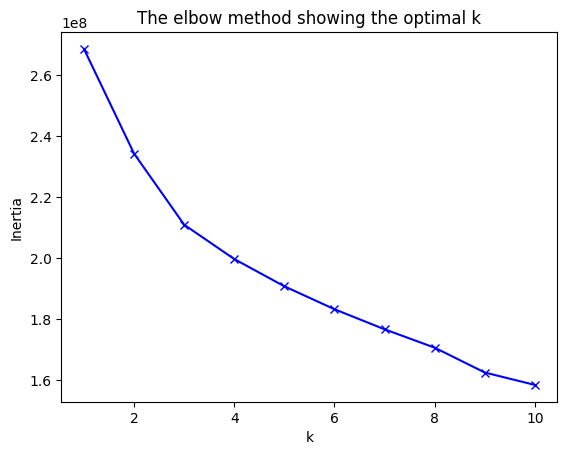

In [449]:
# loop over values of k from 1 to 10
inertias = []
K = 10
for k in range(1, K+1):
    # instantiate the KMeans class with k clusters
    kmeans = KMeans(n_clusters= k)
    
    # fit the model to the data
    kmeans.fit(X_train)

    # store the value of the inertia for this value of k
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, K+1), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The elbow method showing the optimal k')




In [450]:
# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=10)
kmeans.fit(X_train)

# predict clusters for the test data
test_clusters = kmeans.predict(X_train)

# evaluate the clustering performance
silhouette_avg = silhouette_score(X_train, test_clusters)
print("Silhouette Score:", silhouette_avg)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.13400035549519346


Silhouette Score: 0.1682914660492314
Number of clusters identified: 3


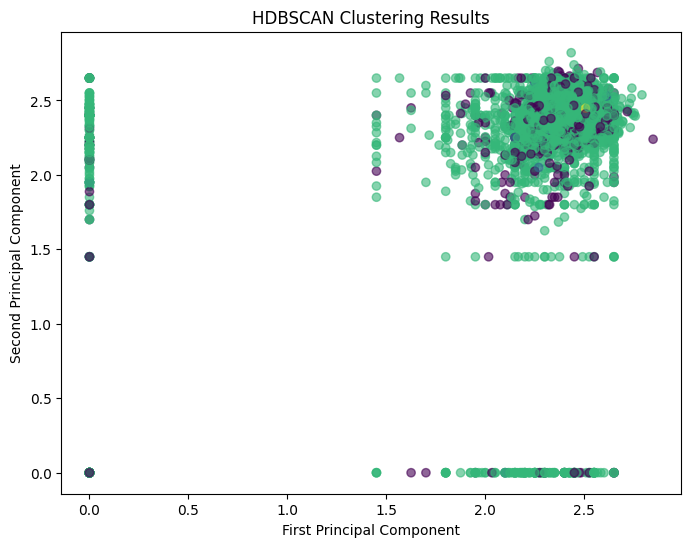

In [451]:
# initialize HDBSCAN with default parameters --> I will try to do more with changing parameter
clusterer = hdbscan.HDBSCAN()

# fit the model
clusterer.fit(X_train)

# predict clusters for the test data
test_clusters = clusterer.fit_predict(X_train)

# evaluate clusters
silhouette_avg = silhouette_score(X_train, test_clusters)
print("Silhouette Score:", silhouette_avg)

num_clusters = len(np.unique(clusterer.labels_)) - 1  # -1 because I want to exclude noise points
print("Number of clusters identified:", num_clusters)

plt.figure(figsize=(8, 6))
plt.scatter(X_train.iloc[:, 1], X_train.iloc[:, 2], c=test_clusters, cmap='viridis', alpha=0.6)
plt.title("HDBSCAN Clustering Results")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()



In [452]:
# reset index
X_train.reset_index(inplace=True)

# Feature 2 with all business but with PCA

In [453]:
feature_2 = feature_1
feature_2

to_randomly_generated_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,CHILDRENDS_SHOP,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
0,0.0,2.397845,2.301282,108.930000,11.812500,0.000000,0.000000,0.0,3.900000,0.000000,...,0.000000,27.500,0.0,0.0,52.000000,13.18,11.475000,0.000,11.458333,52.490
1,0.0,2.328302,2.378261,96.796000,11.672727,0.000000,0.000000,0.0,5.000000,0.000000,...,0.000000,0.000,113.0,0.0,41.285714,41.36,12.166667,49.990,0.000000,52.490
2,0.0,2.359322,2.327372,20.824375,11.600962,0.000000,21.474237,21.8,3.666667,0.000000,...,55.571429,0.000,0.0,0.0,42.750000,0.00,13.500000,14.490,0.000000,49.990
3,0.0,0.000000,2.037500,18.994000,7.118182,0.000000,21.521739,26.0,3.666667,59.000000,...,0.000000,0.000,0.0,0.0,0.000000,14.09,1.500000,29.990,1.500000,10.000
4,0.0,2.245455,2.554545,93.366667,11.734694,0.000000,0.000000,18.0,4.122222,20.000000,...,0.000000,41.590,0.0,0.0,43.000000,10.45,12.071429,29.990,14.555556,74.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8137,0.0,2.297656,2.275385,19.745000,11.082278,0.000000,23.925098,0.0,4.285714,0.000000,...,81.000000,13.865,90.0,0.0,42.125000,24.32,13.000000,49.990,10.750000,14.995
8138,0.0,2.344340,2.486275,87.778182,12.397196,20.000000,0.000000,0.0,4.166667,0.000000,...,0.000000,15.910,0.0,0.0,0.000000,0.00,11.769231,42.495,12.500000,0.000
8139,0.0,2.295000,2.256481,100.068947,11.292000,11.333333,0.000000,27.0,4.063830,78.000000,...,0.000000,21.820,90.0,0.0,24.000000,0.00,11.750000,19.990,12.062500,8.990
8140,0.0,2.316667,2.650000,84.798571,11.344037,0.000000,0.000000,0.0,4.666667,0.000000,...,0.000000,15.450,38.0,0.0,22.000000,0.00,11.875000,24.990,11.857143,21.660


### Principal Component Analysis

I will projects the data from the original 79-dimensional space to lower dimensional space.

In [454]:
n_components = 0.95
whiten = False # transformed data = scale as the original data
random_state = 10

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

In [455]:
X_train, X_test = train_test_split(feature_2, test_size=0.2, random_state=10)

In [456]:
X_train_PCA = pca.fit_transform(X_train)
train_index = range(0,len(X_train))
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)
X_train_PCA

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,-62.525726,106.019040,-31.457859,-21.204610,15.867474,-60.348131,-129.919965,92.468079,-97.920517,41.617750,...,9.764984,-12.532048,-15.996304,3.761376,-6.911207,-6.994265,-6.425828,-5.253702,54.138102,19.785936
1,92.104781,-43.607245,106.153372,29.931166,14.835794,-16.974381,-24.154074,-18.176536,4.363092,-1.043009,...,-22.043272,8.908593,24.528488,-2.982161,0.598320,0.328949,-2.278782,3.568344,-5.161459,-14.034057
2,-108.332086,-17.380355,-66.030518,-13.045041,-3.044972,-63.694635,38.003899,23.718035,-5.835926,-8.923411,...,2.017081,-11.371969,-25.461122,24.215781,8.939887,-1.530471,-20.705303,16.935403,21.204317,13.263068
3,-102.881957,87.573464,-5.777881,4.087886,37.728979,17.407994,58.258070,-112.454725,-58.418138,-6.989564,...,-8.242564,-17.801459,15.768263,-20.083899,-48.721982,-7.928384,-59.038817,-28.508482,-8.377569,7.037643
4,56.603271,-39.581169,9.483676,19.776372,27.557763,52.005633,-8.863251,7.205198,2.897744,-0.442254,...,-14.952063,9.125226,19.915565,4.492089,-14.273574,-11.381831,1.651964,-11.728556,-16.313219,5.692658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,-87.528980,-24.475139,-52.245836,41.098492,-10.004823,74.781847,-20.580190,-7.352071,1.738343,-11.907988,...,-7.258381,17.816231,-8.869035,7.291670,-4.819808,-0.182341,-4.186978,0.594016,-17.873532,23.301023
6509,-0.161095,244.185651,106.823514,92.255437,41.260137,-37.416676,118.024752,-150.894310,58.188025,-31.066355,...,-21.091526,-17.987476,5.592677,13.263373,-0.765760,-3.714620,-19.277472,39.370551,-21.485136,13.496990
6510,83.014384,-42.547861,101.719982,16.460321,-18.878538,-4.540137,-22.360376,-24.168714,1.644842,7.540951,...,5.893528,0.147039,9.617374,-16.791037,15.178680,-1.985223,9.847225,-31.455873,-1.608620,-8.679797
6511,-90.022495,156.902643,-49.976810,-10.437227,-10.072943,-58.817306,-81.781766,29.729565,-124.679172,-17.281990,...,-45.238443,-18.143050,24.054029,15.353129,-21.647173,-13.817757,-13.421476,-9.683190,0.332739,-24.898763


In [457]:
# percentage of Variance Captured by 79 principal components
print("Variance Explained by all 79 principal components: ", \
      sum(pca.explained_variance_ratio_))

Variance Explained by all 79 principal components:  0.9539008925901242


it retaining all the information present in the original data

In [458]:
# Percentage of Variance Captured by X principal components
importanceOfPrincipalComponents = \
    pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print('Variance Captured by First 10 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:9].sum(axis=1).values)
print('Variance Captured by First 20 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:19].sum(axis=1).values)
print('Variance Captured by First 30 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:29].sum(axis=1).values)
print('Variance Captured by First 40 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:40].sum(axis=1).values)
print('Variance Captured by First 50 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:49].sum(axis=1).values)


Variance Captured by First 10 Principal Components:  [0.73871552]
Variance Captured by First 20 Principal Components:  [0.87041904]
Variance Captured by First 30 Principal Components:  [0.94793157]
Variance Captured by First 40 Principal Components:  [0.95390089]
Variance Captured by First 50 Principal Components:  [0.95390089]


The first 10 components in total capture approximately 70% of the variance, the 30th , 40th, 50th components almost 95% of the variance.

With just the first 30th principal components (far fewer than the original 79 dimensions), we capture almost 95% of the variance/information.

In [459]:
X_test_PCA = pca.transform(X_test)
X_test_PCA.shape

(1629, 31)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Text(0.5, 1.0, 'The elbow method showing the optimal k')

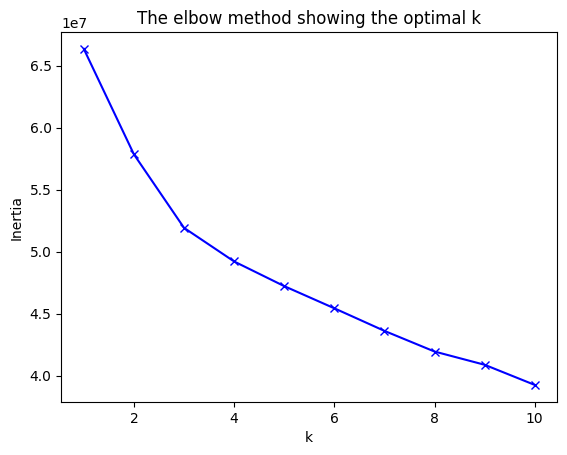

In [460]:
# fit PCA to the training data
pca = PCA(n_components=79, random_state=10)
X_train_PCA = pca.fit_transform(X_train)

# transform the test data using the same PCA object
X_test_PCA = pca.transform(X_test)

# loop over k from 1 to 10
inertias = []
K = 10
for k in range(1, K+1):
    # instantiate the KMeans class
    kmeans = KMeans(n_clusters= k)
    
    # fit the model
    kmeans.fit(X_test_PCA)

    # append the value of the inertia for this value of k
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, K+1), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The elbow method showing the optimal k')




In [461]:
# apply K-means clustering to the reduced-dimensional features
kmeans = KMeans(n_clusters=3, random_state=10)
kmeans.fit(X_train_PCA)

# predict clusters for the test data
test_clusters = kmeans.predict(X_test_PCA)

# evaluate the clustering performance
silhouette_avg = silhouette_score(X_test_PCA, test_clusters)
print("Silhouette Score:", silhouette_avg)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.1397094990232284


In [462]:
# apply K-means clustering to the reduced-dimensional features
kmeans = KMeans(n_clusters=4, random_state=10)
kmeans.fit(X_train_PCA)

# predict clusters for the test data
test_clusters = kmeans.predict(X_test_PCA)

# evaluate the clustering performance
silhouette_avg = silhouette_score(X_test_PCA, test_clusters)
print("Silhouette Score:", silhouette_avg)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.12134541859711725


## DBSCAN

In [463]:
X_train_PCA

array([[-6.25257260e+01,  1.06019040e+02, -3.14578587e+01, ...,
        -4.89415039e-02, -1.19333632e-02,  5.72714776e-02],
       [ 9.21047811e+01, -4.36072447e+01,  1.06153372e+02, ...,
         4.04457551e-02,  1.24824620e-01,  1.29286386e-01],
       [-1.08332086e+02, -1.73803547e+01, -6.60305182e+01, ...,
        -7.11403098e-02, -7.31296114e-02, -5.82178740e-02],
       ...,
       [ 8.30143844e+01, -4.25478609e+01,  1.01719982e+02, ...,
        -1.82118064e+00, -7.67097114e-01,  2.28668589e-01],
       [-9.00224949e+01,  1.56902643e+02, -4.99768104e+01, ...,
        -1.22476189e-01,  9.36238552e-02,  1.20204242e-01],
       [-6.32734359e-02, -3.47234484e+01, -1.75678589e+01, ...,
        -2.63215884e-02, -2.57647129e-02,  8.29743886e-02]])

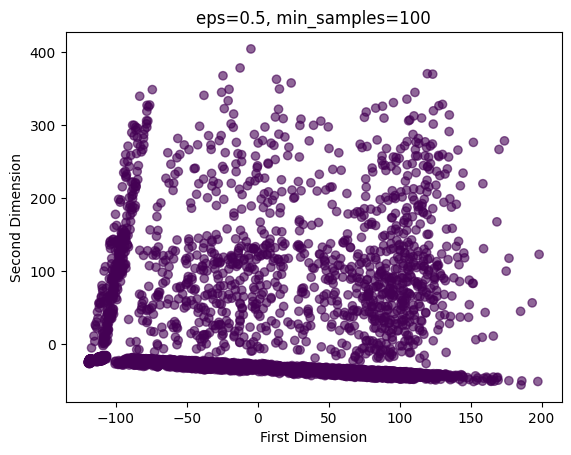

In [464]:
dbscan = DBSCAN(eps=0.5, min_samples=100)
test_clusters = dbscan.fit_predict(X_train_PCA)


plt.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1], c=test_clusters, cmap='viridis', alpha=0.6)
plt.title(f"eps=0.5, min_samples=100")
plt.xlabel("First Dimension")
plt.ylabel("Second Dimension")

plt.show()


## HDBSCAN

In [465]:
# initialize HDBSCAN
clusterer = hdbscan.HDBSCAN()

# fit model
clusterer.fit(X_train_PCA)

# predict clusters for the test data
test_clusters = clusterer.fit_predict(X_test_PCA)

# evaluate the clusters
silhouette_avg = silhouette_score(X_test_PCA, test_clusters)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.008354677458015124


In [466]:
# count the number of unique cluster labels
num_clusters = len(np.unique(clusterer.labels_)) - 1  # Exclude noise points (-1)
print("Number of clusters identified:", num_clusters)


Number of clusters identified: 2


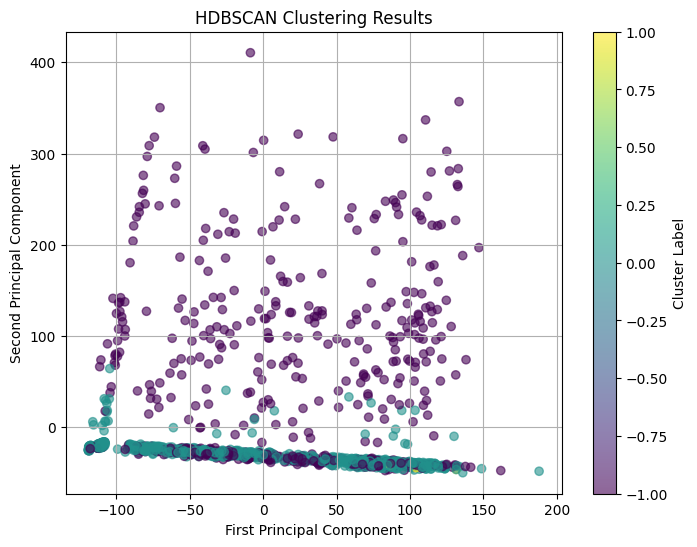

In [467]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test_PCA[:, 0], X_test_PCA[:, 1], c=test_clusters, cmap='viridis', alpha=0.6)
plt.title("HDBSCAN Clustering Results")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()


# Feature 3 top 3 and 6 spending
Find only amount in spending top 3 and 6 to see potential money spending (social status group)

In [468]:
fake_transaction

,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date
0,10371.0,4.00,CINEMA,01/01/2025
1,18555.0,4.10,HIPSTER_COFFEE_SHOP,01/01/2025
2,18555.0,4.45,TOTALLY_A_REAL_COFFEE_SHOP,01/01/2025
3,18555.0,1.45,COFFEE_SHOP,01/01/2025
4,18555.0,5.00,CAFE,01/01/2025
...,...,...,...,...
7615512,81404.0,1.80,TOTALLY_A_REAL_COFFEE_SHOP,31/12/2025
7615513,32185.0,2.65,COFFEE_SHOP,31/12/2025
7615514,32185.0,2.45,COFFEE_SHOP,31/12/2025
7615515,57569.0,14.00,WINE_BAR,31/12/2025


In [469]:
aggregated_data = fake_transaction.groupby('from_totally_fake_account')['monopoly_money_amount'].sum().reset_index()
aggregated_data

,from_totally_fake_account,monopoly_money_amount
0,1000.0,10485.46
1,1002.0,9155.67
2,1006.0,14715.49
3,1018.0,11304.51
4,1053.0,13139.22
...,...,...
8137,100931.0,15520.06
8138,100934.0,13512.25
8139,100947.0,15986.22
8140,100986.0,12662.36


In [470]:
# filter out non-numeric values from 'monopoly_money_amount' column
fake_transaction['monopoly_money_amount'] = pd.to_numeric(fake_transaction['monopoly_money_amount'], errors='coerce')

#fake_transaction.dropna(subset=['monopoly_money_amount'], inplace=True)
fake_transaction.fillna(0)

# group by and calculate the sum
agg_result = fake_transaction.groupby(['from_totally_fake_account', 'to_randomly_generated_account'])['monopoly_money_amount'].sum()

# reset the index
agg_result = agg_result.reset_index()

# get the top 3 values for each group
def get_top_3(group):
    return group.nlargest(3, 'monopoly_money_amount')

# group by and apply the function to get the top 3 values
top_3_values = agg_result.groupby('from_totally_fake_account').apply(get_top_3)

# use 'from_totally_fake_account'as an index and drop the existing index
top_3_values.reset_index(drop=True, inplace=True)


top_3_pivot = top_3_values.pivot_table(index='from_totally_fake_account', columns=top_3_values.groupby('from_totally_fake_account').cumcount() + 1, values='monopoly_money_amount')
top_3_pivot.columns = [f'top_{col}' for col in top_3_pivot.columns]

print(top_3_pivot)


                             top_1    top_2    top_3
from_totally_fake_account                           
1000.0                     1316.00   850.50   550.00
1002.0                     1489.42  1284.00  1046.50
1006.0                     1610.28  1429.71  1266.98
1018.0                     1148.00  1038.00   990.00
1053.0                     1723.00  1295.85  1150.00
...                            ...      ...      ...
100931.0                   2016.59  1751.00  1334.00
100934.0                   1906.45  1658.14  1326.50
100947.0                   1901.31  1460.90  1411.50
100986.0                   1841.74  1520.87  1236.50
100988.0                   1262.41  1167.00   853.00

[8142 rows x 3 columns]


In [471]:
# get the corresponding 'to_randomly_generated_account' for each top spending amount
def get_top_account(top_value, agg_result):
   # get the 'to_randomly_generated_account' corresponding to the top spending amount
    top_account = agg_result.loc[agg_result['monopoly_money_amount'] == top_value, 'to_randomly_generated_account'].values[0]
    return top_account

# map the top spending amounts to the corresponding 'to_randomly_generated_account' for each top
top_3_pivot['top_1_account'] = top_3_pivot['top_1'].apply(lambda x: get_top_account(x, agg_result))
top_3_pivot['top_2_account'] = top_3_pivot['top_2'].apply(lambda x: get_top_account(x, agg_result))
top_3_pivot['top_3_account'] = top_3_pivot['top_3'].apply(lambda x: get_top_account(x, agg_result))
print(top_3_pivot)



                             top_1    top_2    top_3        top_1_account  \
from_totally_fake_account                                                   
1000.0                     1316.00   850.50   550.00                  PUB   
1002.0                     1489.42  1284.00  1046.50                  PUB   
1006.0                     1610.28  1429.71  1266.98                  PUB   
1018.0                     1148.00  1038.00   990.00     DEPARTMENT_STORE   
1053.0                     1723.00  1295.85  1150.00         FASHION_SHOP   
...                            ...      ...      ...                  ...   
100931.0                   2016.59  1751.00  1334.00                  PUB   
100934.0                   1906.45  1658.14  1326.50  EXPRESS_SUPERMARKET   
100947.0                   1901.31  1460.90  1411.50        A_SUPERMARKET   
100986.0                   1841.74  1520.87  1236.50                  PUB   
100988.0                   1262.41  1167.00   853.00                  PUB   

In [472]:
pd.DataFrame(top_3_pivot)

,top_1,top_2,top_3,top_1_account,top_2_account,top_3_account
from_totally_fake_account,,,,,,
1000.0,1316.00,850.50,550.00,PUB,BAR,WINE_BAR
1002.0,1489.42,1284.00,1046.50,PUB,BAR,LOCAL_WATERING_HOLE
1006.0,1610.28,1429.71,1266.98,PUB,GREENGROCER,BUTCHER
1018.0,1148.00,1038.00,990.00,DEPARTMENT_STORE,FASHION_SHOP,BUTCHER
1053.0,1723.00,1295.85,1150.00,FASHION_SHOP,PUB,BAR
...,...,...,...,...,...,...
100931.0,2016.59,1751.00,1334.00,PUB,BAR,CLOTHES_SHOP
100934.0,1906.45,1658.14,1326.50,EXPRESS_SUPERMARKET,THE_SUPERMARKET,BAR
100947.0,1901.31,1460.90,1411.50,A_SUPERMARKET,THE_SUPERMARKET,BAR


In [473]:
# create LabelEncoder 
label_encoder = LabelEncoder()

# encode categorical column
top_3_pivot['top_1_account_encoded'] = label_encoder.fit_transform(top_3_pivot['top_1_account'])
top_3_pivot['top_2_account_encoded'] = label_encoder.fit_transform(top_3_pivot['top_2_account'])
top_3_pivot['top_3_account_encoded'] = label_encoder.fit_transform(top_3_pivot['top_3_account'])

print(top_3_pivot)


                             top_1    top_2    top_3        top_1_account  \
from_totally_fake_account                                                   
1000.0                     1316.00   850.50   550.00                  PUB   
1002.0                     1489.42  1284.00  1046.50                  PUB   
1006.0                     1610.28  1429.71  1266.98                  PUB   
1018.0                     1148.00  1038.00   990.00     DEPARTMENT_STORE   
1053.0                     1723.00  1295.85  1150.00         FASHION_SHOP   
...                            ...      ...      ...                  ...   
100931.0                   2016.59  1751.00  1334.00                  PUB   
100934.0                   1906.45  1658.14  1326.50  EXPRESS_SUPERMARKET   
100947.0                   1901.31  1460.90  1411.50        A_SUPERMARKET   
100986.0                   1841.74  1520.87  1236.50                  PUB   
100988.0                   1262.41  1167.00   853.00                  PUB   

In [474]:
print(top_3_pivot)

                             top_1    top_2    top_3        top_1_account  \
from_totally_fake_account                                                   
1000.0                     1316.00   850.50   550.00                  PUB   
1002.0                     1489.42  1284.00  1046.50                  PUB   
1006.0                     1610.28  1429.71  1266.98                  PUB   
1018.0                     1148.00  1038.00   990.00     DEPARTMENT_STORE   
1053.0                     1723.00  1295.85  1150.00         FASHION_SHOP   
...                            ...      ...      ...                  ...   
100931.0                   2016.59  1751.00  1334.00                  PUB   
100934.0                   1906.45  1658.14  1326.50  EXPRESS_SUPERMARKET   
100947.0                   1901.31  1460.90  1411.50        A_SUPERMARKET   
100986.0                   1841.74  1520.87  1236.50                  PUB   
100988.0                   1262.41  1167.00   853.00                  PUB   

In [475]:
top_3_pivot.drop(['top_1_account', 'top_2_account', 'top_3_account'], axis=1, inplace=True)


In [476]:
top_3_pivot

,top_1,top_2,top_3,top_1_account_encoded,top_2_account_encoded,top_3_account_encoded
from_totally_fake_account,,,,,,
1000.0,1316.00,850.50,550.00,12,1,39
1002.0,1489.42,1284.00,1046.50,12,1,24
1006.0,1610.28,1429.71,1266.98,12,13,2
1018.0,1148.00,1038.00,990.00,5,11,2
1053.0,1723.00,1295.85,1150.00,7,21,1
...,...,...,...,...,...,...
100931.0,2016.59,1751.00,1334.00,12,1,6
100934.0,1906.45,1658.14,1326.50,6,28,1
100947.0,1901.31,1460.90,1411.50,0,28,1


In [477]:
top_3_pivot.columns

Index(['top_1', 'top_2', 'top_3', 'top_1_account_encoded',
       'top_2_account_encoded', 'top_3_account_encoded'],
      dtype='object')

In [478]:
top_3_pivot['top_2_account_encoded'].unique()

array([ 1, 13, 11, 21, 20, 28,  2,  0,  9,  5,  7,  6, 31, 27, 18,  4, 14,
       12, 29, 30, 23, 19, 16,  3,  8, 17, 26, 24, 15, 10, 22, 25])

In [479]:
X_train, X_test = train_test_split(top_3_pivot, test_size=0.2, random_state=10)

In [480]:
X_train

,top_1,top_2,top_3,top_1_account_encoded,top_2_account_encoded,top_3_account_encoded
from_totally_fake_account,,,,,,
100273.0,1934.83,1496.48,1324.52,10,28,10
100573.0,1697.29,1264.20,1226.46,12,13,2
48620.0,1771.31,1176.00,1012.00,12,1,24
55890.0,1322.14,937.00,869.50,8,1,15
6575.0,1872.70,1480.00,1193.00,12,1,8
...,...,...,...,...,...,...
43130.0,2269.49,1536.85,1317.01,10,0,25
17328.0,1637.94,1339.50,1244.00,12,1,24
57429.0,1233.07,984.50,964.15,2,20,15


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Text(0.5, 1.0, 'The elbow method showing the optimal k')

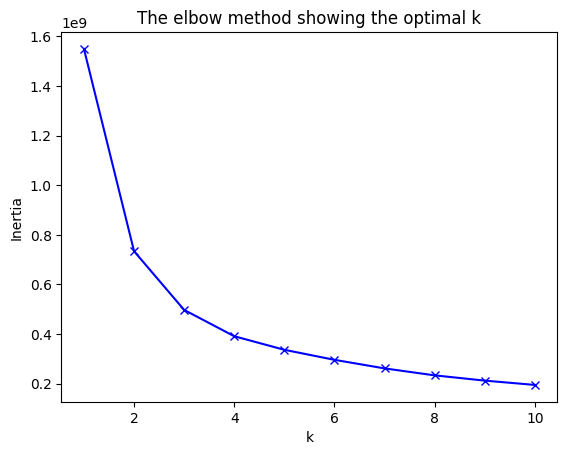

In [481]:
# loop over values of k from 1 to 10
inertias = []
K = 10
for k in range(1, K+1):
    # instantiate the KMeans class with k clusters
    kmeans = KMeans(n_clusters= k)
    
    # fit the model to the data
    kmeans.fit(X_train)

    # store the value of the inertia for this value of k
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, K+1), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The elbow method showing the optimal k')



In [482]:
# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=10)
kmeans.fit(X_train)

# predict clusters for the test data
test_clusters = kmeans.predict(X_train)

# evaluate the clustering performance
silhouette_avg = silhouette_score(X_train, test_clusters)
print("Silhouette Score:", silhouette_avg)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.37599777504140414


Silhouette Score: 0.5214512851245418
Number of clusters identified: 2


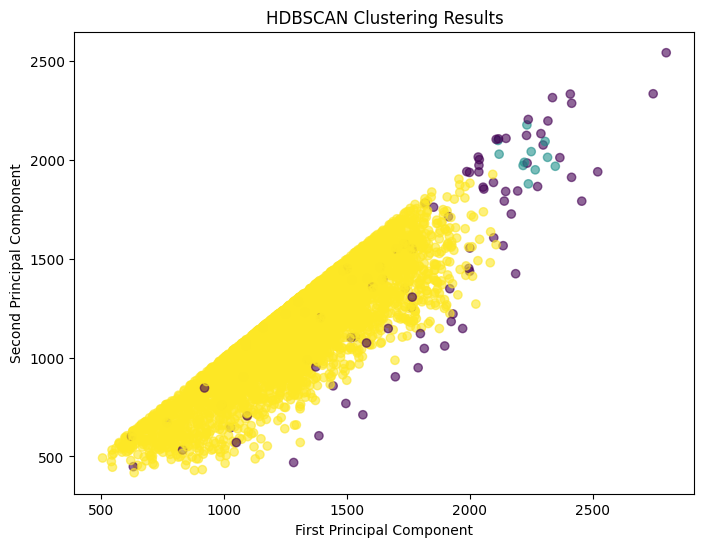

In [483]:
# initialize HDBSCAN
clusterer = hdbscan.HDBSCAN()

# fit model
clusterer.fit(X_train)

# predict clusters
test_clusters = clusterer.fit_predict(X_train)

# evaluate the clusters
silhouette_avg = silhouette_score(X_train, test_clusters)
print("Silhouette Score:", silhouette_avg)

# count the number of unique cluster labels
num_clusters = len(np.unique(clusterer.labels_)) - 1  # Exclude noise points (-1)
print("Number of clusters identified:", num_clusters)

plt.figure(figsize=(8, 6))
plt.scatter(X_train.iloc[:, 1], X_train.iloc[:, 2], c=test_clusters, cmap='viridis', alpha=0.6)
plt.title("HDBSCAN Clustering Results")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()



## Top 3 without encode

In [484]:
# filter out non-numeric values from the 'monopoly_money_amount' column
fake_transaction['monopoly_money_amount'] = pd.to_numeric(fake_transaction['monopoly_money_amount'], errors='coerce')

#fake_transaction.dropna(subset=['monopoly_money_amount'], inplace=True)
fake_transaction.fillna(0)

# group by and calculate the sum
agg_result = fake_transaction.groupby(['from_totally_fake_account', 'to_randomly_generated_account'])['monopoly_money_amount'].sum()

# reset the index
agg_result = agg_result.reset_index()

# get the top 3 values for each group
def get_top_3(group):
    return group.nlargest(3, 'monopoly_money_amount')

# group by and apply the function to get the top 3 values
top_3_values = agg_result.groupby('from_totally_fake_account').apply(get_top_3)

# use 'from_totally_fake_account'as an index and drop the existing index
top_3_values.reset_index(drop=True, inplace=True)


top_3_pivot = top_3_values.pivot_table(index='from_totally_fake_account', columns=top_3_values.groupby('from_totally_fake_account').cumcount() + 1, values='monopoly_money_amount')
top_3_pivot.columns = [f'top_{col}' for col in top_3_pivot.columns]

print(top_3_pivot)


                             top_1    top_2    top_3
from_totally_fake_account                           
1000.0                     1316.00   850.50   550.00
1002.0                     1489.42  1284.00  1046.50
1006.0                     1610.28  1429.71  1266.98
1018.0                     1148.00  1038.00   990.00
1053.0                     1723.00  1295.85  1150.00
...                            ...      ...      ...
100931.0                   2016.59  1751.00  1334.00
100934.0                   1906.45  1658.14  1326.50
100947.0                   1901.31  1460.90  1411.50
100986.0                   1841.74  1520.87  1236.50
100988.0                   1262.41  1167.00   853.00

[8142 rows x 3 columns]


In [485]:
X_train, X_test = train_test_split(top_3_pivot, test_size=0.2, random_state=10)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Text(0.5, 1.0, 'The elbow method showing the optimal k')

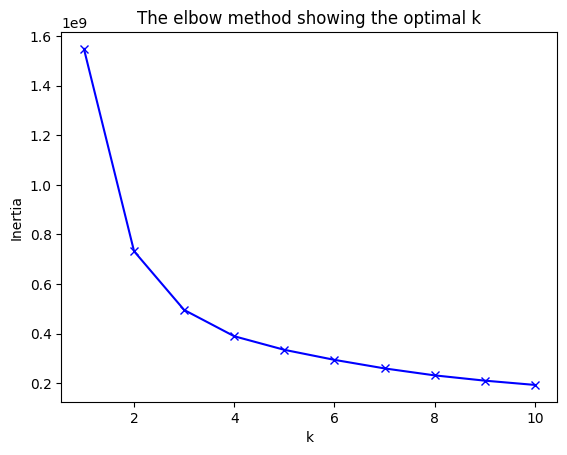

In [486]:
# loop over values of k from 1 to 10
inertias = []
K = 10
for k in range(1, K+1):
    # instantiate the KMeans class with k clusters
    kmeans = KMeans(n_clusters= k)
    
    # fit the model to the data
    kmeans.fit(X_train)

    # store the value of the inertia for this value of k
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, K+1), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The elbow method showing the optimal k')



In [487]:
# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=10)
kmeans.fit(X_train)

# predict clusters for the test data
test_clusters = kmeans.predict(X_train)

# evaluate the clustering performance
silhouette_avg = silhouette_score(X_train, test_clusters)
print("Silhouette Score:", silhouette_avg)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.43863338590657075


Silhouette Score: 0.5212410725329547
Number of clusters identified: 2


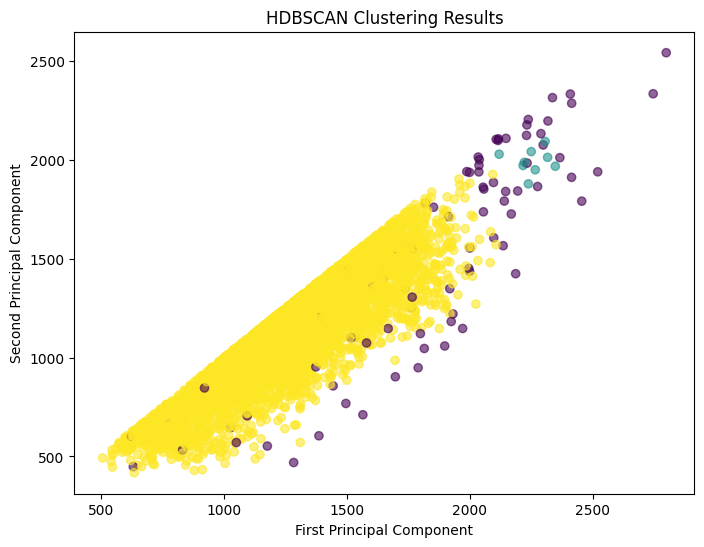

In [488]:
# initialize HDBSCAN
clusterer = hdbscan.HDBSCAN()

# fit model
clusterer.fit(X_train)

# predict clusters
test_clusters = clusterer.fit_predict(X_train)

# evaluate the clusters
silhouette_avg = silhouette_score(X_train, test_clusters)
print("Silhouette Score:", silhouette_avg)

# count the number of unique cluster labels
num_clusters = len(np.unique(clusterer.labels_)) - 1  # Exclude noise points (-1)
print("Number of clusters identified:", num_clusters)

plt.figure(figsize=(8, 6))
plt.scatter(X_train.iloc[:, 1], X_train.iloc[:, 2], c=test_clusters, cmap='viridis', alpha=0.6)
plt.title("HDBSCAN Clustering Results")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()



## Top 6

In [489]:
# filter out non-numeric values from the 'monopoly_money_amount' column
fake_transaction['monopoly_money_amount'] = pd.to_numeric(fake_transaction['monopoly_money_amount'], errors='coerce')

fake_transaction.fillna(0)

# group by and calculate the sum
agg_result = fake_transaction.groupby(['from_totally_fake_account', 'to_randomly_generated_account'])['monopoly_money_amount'].sum()

# reset the index
agg_result = agg_result.reset_index()

# get the top 6 values for each group
def get_top_6(group):
    return group.nlargest(6, 'monopoly_money_amount')

# group by and apply the function to get the top 6 values
top_6_values = agg_result.groupby('from_totally_fake_account').apply(get_top_6)

# reset the index 
top_6_values.reset_index(drop=True, inplace=True)

top_6_pivot = top_6_values.pivot_table(index='from_totally_fake_account', columns=top_6_values.groupby('from_totally_fake_account').cumcount() + 1, values='monopoly_money_amount')

top_6_pivot.columns = [f'top_{col}' for col in top_6_pivot.columns]

print(top_6_pivot)


                             top_1    top_2    top_3    top_4    top_5  \
from_totally_fake_account                                                
1000.0                     1316.00   850.50   550.00   459.00   441.00   
1002.0                     1489.42  1284.00  1046.50   483.98   458.55   
1006.0                     1610.28  1429.71  1266.98  1206.50   961.00   
1018.0                     1148.00  1038.00   990.00   971.00   962.75   
1053.0                     1723.00  1295.85  1150.00   886.00   838.00   
...                            ...      ...      ...      ...      ...   
100931.0                   2016.59  1751.00  1334.00  1220.18  1209.88   
100934.0                   1906.45  1658.14  1326.50  1231.11  1186.36   
100947.0                   1901.31  1460.90  1411.50  1393.14  1330.50   
100986.0                   1841.74  1520.87  1236.50   915.56   901.50   
100988.0                   1262.41  1167.00   853.00   810.00   722.00   

                             top_6  


In [490]:
X_train, X_test = train_test_split(top_6_pivot, test_size=0.2, random_state=10)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Text(0.5, 1.0, 'The elbow method showing the optimal k')

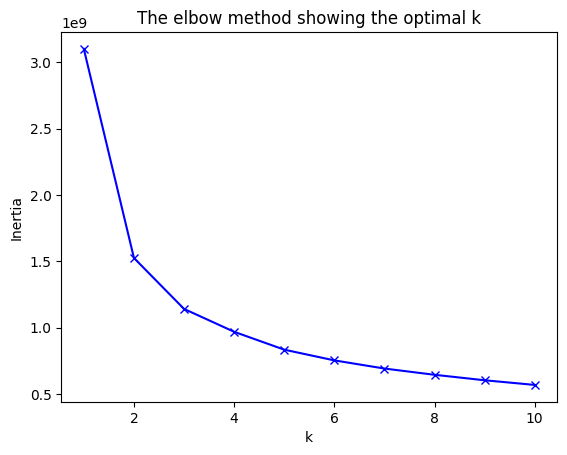

In [491]:
# loop over values of k from 1 to 10
inertias = []
K = 10
for k in range(1, K+1):
    # instantiate the KMeans class with k clusters
    kmeans = KMeans(n_clusters= k)
    
    # fit the model to the data
    kmeans.fit(X_train)

    # store the value of the inertia for this value of k
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, K+1), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The elbow method showing the optimal k')



In [492]:
# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=10)
kmeans.fit(X_train)

# predict clusters for the test data
test_clusters = kmeans.predict(X_train)

# evaluate the clustering performance
silhouette_avg = silhouette_score(X_train, test_clusters)
print("Silhouette Score:", silhouette_avg)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.4102255785812426


Silhouette Score: 0.47750660220010827
Number of clusters identified: 2


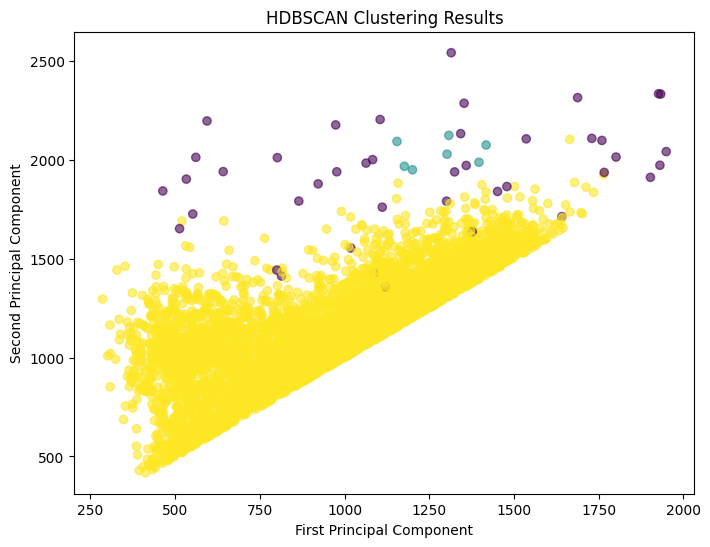

In [493]:
# initialize HDBSCAN
clusterer = hdbscan.HDBSCAN()

clusterer.fit(X_train)
test_clusters = clusterer.fit_predict(X_train)

# evaluate the clusters
silhouette_avg = silhouette_score(X_train, test_clusters)
print("Silhouette Score:", silhouette_avg)

# count the number of unique cluster labels
num_clusters = len(np.unique(clusterer.labels_)) - 1  # Exclude noise points (-1)
print("Number of clusters identified:", num_clusters)
                                                             
plt.figure(figsize=(8, 6))
plt.scatter(X_train.iloc[:, 3], X_train.iloc[:, 2], c=test_clusters, cmap='viridis', alpha=0.6)
plt.title("HDBSCAN Clustering Results")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

